# Sentiment Analysis on Movie Reviews

The sentiment labels are:
- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 

## Data Loading and Preparation

In [2]:
train = pd.read_table('../input/movie-review-sentiment-analysis-kernels-only/train.tsv',delimiter="\t",encoding="utf-8")
test = pd.read_table('../input/movie-review-sentiment-analysis-kernels-only/test.tsv',delimiter="\t",encoding="utf-8")
submission = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv')

In [3]:
submission.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


In [4]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


## Data Modeling

In [6]:
df = pd.concat([train, test], ignore_index=True)
print(df.shape)

(222352, 4)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [7]:
df.head()

,Phrase,PhraseId,SentenceId,Sentiment
0,A series of escapades demonstrating the adage ...,1,1,1.0
1,A series of escapades demonstrating the adage ...,2,1,2.0
2,A series,3,1,2.0
3,A,4,1,2.0
4,series,5,1,2.0


In [8]:
df.tail()

,Phrase,PhraseId,SentenceId,Sentiment
222347,"A long-winded , predictable scenario .",222348,11855,NaN
222348,"A long-winded , predictable scenario",222349,11855,NaN
222349,"A long-winded ,",222350,11855,NaN
222350,A long-winded,222351,11855,NaN
222351,predictable scenario,222352,11855,NaN


In [9]:
newStemmer = SnowballStemmer('english')
newLemma = WordNetLemmatizer()

#### Algorithm to clean the existing reviews before processing them into our model

In [10]:
def cleaning(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[newLemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [11]:
df['optimized_reviews']=cleaning(df.Phrase.values)
df.head()

,Phrase,PhraseId,SentenceId,Sentiment,optimized_reviews
0,A series of escapades demonstrating the adage ...,1,1,1.0,a series of escapade demonstrating the adage t...
1,A series of escapades demonstrating the adage ...,2,1,2.0,a series of escapade demonstrating the adage t...
2,A series,3,1,2.0,a series
3,A,4,1,2.0,a
4,series,5,1,2.0,series


In [12]:
tfidf=TfidfVectorizer(ngram_range=(1,2),max_df=0.95,min_df=10,sublinear_tf=True)

In [13]:
df_train=df[df.Sentiment!=-999]
df_train.shape

(222352, 5)

In [14]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(0, 4)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Phrase,PhraseId,SentenceId,optimized_reviews


## Data Preprocessing and Elementary EDA

<b>Check if the data containes Null or NaNs</b>

In [15]:
train.isna().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [16]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

<b> Below, we are converting the sentiment score to its meaningful string assignment to be used during the analysis</b>

In [17]:
train['sentiment_label'] = ''
train.loc[train.Sentiment == 0, 'sentiment_label'] = 'Negative'
train.loc[train.Sentiment == 1, 'sentiment_label'] = 'Somewhat Negative'
train.loc[train.Sentiment == 2, 'sentiment_label'] = 'Neutral'
train.loc[train.Sentiment == 3, 'sentiment_label'] = 'Somewhat Positive'
train.loc[train.Sentiment == 4, 'sentiment_label'] = 'Positive'

In [18]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_label
0,1,1,A series of escapades demonstrating the adage ...,1,Somewhat Negative
1,2,1,A series of escapades demonstrating the adage ...,2,Neutral
2,3,1,A series,2,Neutral
3,4,1,A,2,Neutral
4,5,1,series,2,Neutral


<b>Sentiment labels distribution</b>

- The most frequent label is Neutral which represent about 50% from the data.
- The total positive reviews represent about 27%.
- The total negative reviews represent about 23%.

In [19]:
train.sentiment_label.value_counts()

Neutral              79582
Somewhat Positive    32927
Somewhat Negative    27273
Positive              9206
Negative              7072
Name: sentiment_label, dtype: int64

In [20]:
train.shape

(156060, 5)

Below, let us get rid of PhraseId and SentenceId, as these assignments don't help in solving our problem

In [21]:
train = train.drop(['PhraseId', 'SentenceId'], axis=1)

In [22]:
train.head()

,Phrase,Sentiment,sentiment_label
0,A series of escapades demonstrating the adage ...,1,Somewhat Negative
1,A series of escapades demonstrating the adage ...,2,Neutral
2,A series,2,Neutral
3,A,2,Neutral
4,series,2,Neutral


Below, let us analyze the length of each phrase for the reviews

In [23]:
train['lengthOfPhrase'] = [len(x) for x in train.Phrase]
train.head()

,Phrase,Sentiment,sentiment_label,lengthOfPhrase
0,A series of escapades demonstrating the adage ...,1,Somewhat Negative,188
1,A series of escapades demonstrating the adage ...,2,Neutral,77
2,A series,2,Neutral,8
3,A,2,Neutral,1
4,series,2,Neutral,6


Notice that above, the length of each string - by characters - is calculated. Spaces are included.

## Data Visualization - Finding different sentiment distributions

In [24]:
sns.set_palette("dark")

[Text(0, 0, 'Neutral'),
 Text(0, 0, 'Somewhat Positive'),
 Text(0, 0, 'Somewhat Negative'),
 Text(0, 0, 'Positive'),
 Text(0, 0, 'Negative')]

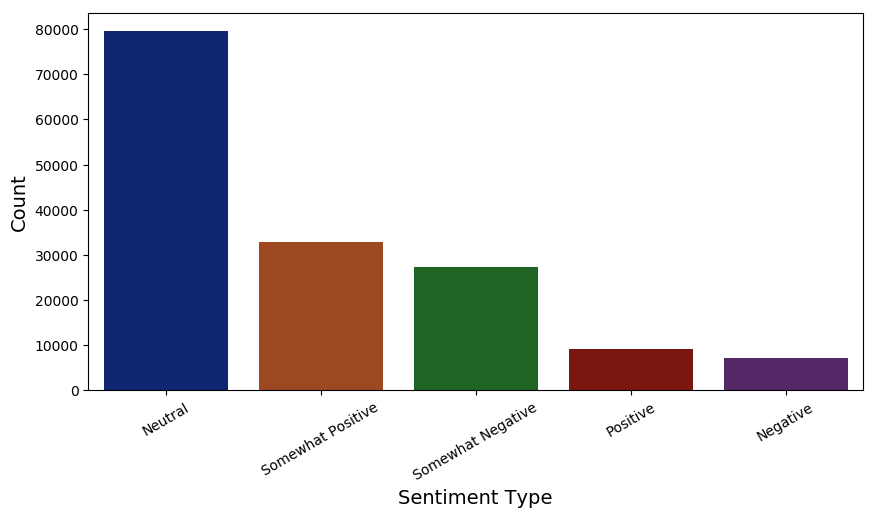

In [25]:
fig, ax = plt.subplots(1, 1,dpi=100, figsize=(10,5))
sentiment_labels = train.sentiment_label.value_counts().index
sentiment_count = train.sentiment_label.value_counts()
sns.barplot(x=sentiment_labels,y=sentiment_count)
ax.set_ylabel('Count', fontsize = 14)    
ax.set_xlabel('Sentiment Type', fontsize = 14)
ax.set_xticklabels(sentiment_labels , rotation=30)

<function matplotlib.pyplot.show(*args, **kw)>

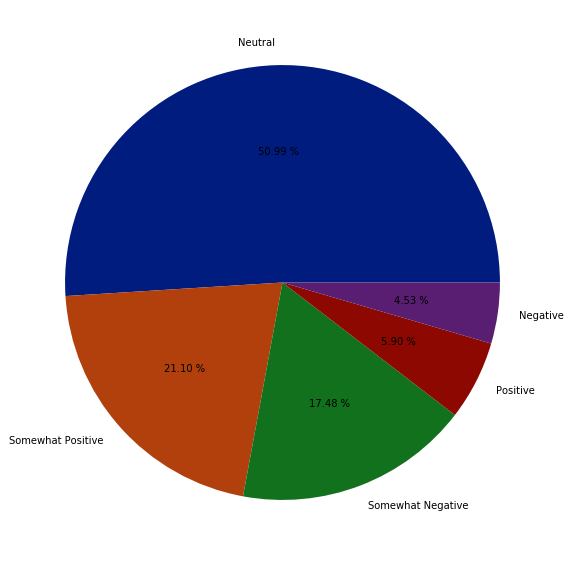

In [26]:
fig = plt.figure(figsize=[10, 10])
sentiment_labels = train.sentiment_label.value_counts().index
sentiment_count = train.sentiment_label.value_counts()
plt.pie(x=sentiment_count, labels=sentiment_labels,autopct='%0.2f %%')
plt.show

#### <b>More Visualizations for better insights :: WordClouds for Positive, Negative and Neutral Reviews.</b>

Define a list of english stopwords to be eliminated from the text during text analysis process.

In [27]:
Stopwords = list(ENGLISH_STOP_WORDS) + stopwords.words()

NameError: name 'ENGLISH_STOP_WORDS' is not defined

In [28]:
def textPreparation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[%s]' % re.escape(string.digits), '', text)
    text = re.sub('[%s]' % re.escape(' +'), ' ', text)
    text = text.lower()
    text = text.strip()
    return text

In [29]:
train['cleaned_phrase'] = ''
train['cleaned_phrase'] = [textPreparation(phrase) for phrase in train.Phrase]
test['cleaned_phrase'] = ''
test['cleaned_phrase'] = [textPreparation(phrase) for phrase in test.Phrase]

In [30]:
def cloud(sentiment):
    stopwordslist = Stopwords
    ## extend list of stopwords with the common words between the 3 classes which is not helpful to represent them
    stopwordslist.extend(['movie','movies','film','nt','rrb','lrb','make','work','like','story','time','little'])
    reviews = train.loc[train.Sentiment.isin(sentiment)]
    print("Word Cloud for Sentiment Labels: ", reviews.sentiment_label.unique())
    phrases = ' '.join(reviews.cleaned_phrase)
    words = " ".join([word for word in phrases.split()])
    wordcloud = WordCloud(stopwords=stopwordslist,width=3000,height=2500,background_color='white',).generate(words)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


In [31]:
cloud([3,4])

NameError: name 'Stopwords' is not defined

In [32]:
cloud([0,1])

NameError: name 'Stopwords' is not defined

Now, this is important. Note we are concerned with neutral wording that may lead to neutral sentiments. Here, we analyze which words are most commonly associated with neutral sentiment within this dataset.Sometimes, just having words like 'good' or 'bad' may not necessarily equivocate to the reviews being positive or negative sentiment. We have to further analyze our data to tryly determine the sentiment.

In [33]:
cloud([2])

NameError: name 'Stopwords' is not defined

#### More Analysis and visualizations: Measuring frequency of words. 

In order to do this, we utilized a model known as Zipf's Law. 

Zipf's Law states that, if $t_1$ is the most common term in the collection, $t_2$ is the next most common, and so on, then the collection frequency cf(i) of the i'th most common term is proportional to $1/i$:

Formula: cf(i) α 1/i

Theoretical Description: Say we have a term that occurs cf1 times, then the next most frequent time has about half the probability of occurance as before. Basically, the frequency decreases with rank. It is a good model that helps formalize a rapid decrease in probability of occurance.

In order to implement the above model, we need to analyze the frequency of terms that appear in the model. We can use sklearn's CountVectorizer to do this.

In [34]:
vectorizor = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2))
vectorizor.fit(train.Phrase)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

#### We are concerned with finding the frequency for negative reviews. So let use our vectorizor model to find the frequency of words that may lead to neutral sentiment

In [35]:
neutral_frequency = vectorizor.transform(train[train.Sentiment == 2].Phrase)

In [36]:
neutral_words = neutral_frequency.sum(axis=0)
neutral_words_frequency = [(word, neutral_words[0, idx]) for word, idx in vectorizor.vocabulary_.items()]
neutral_words_tf = pd.DataFrame(list(sorted(neutral_words_frequency, key = lambda x: x[1], reverse=True)), columns=['Terms', 'neutral'])
neutral_words_tf_df = neutral_words_tf.set_index('Terms')
neutral_words_tf_df.head()

,neutral
Terms,
the,20619
of,12287
and,10241
to,8295
in,5562


#### Below, we are creating a dataframe that we will keep track of to measure neutral phrase/term frequency. We will use this later to create our frequency plot

In [37]:
term_freq_df = pd.concat([neutral_words_tf_df],axis=1)

In [38]:
term_freq_df['total'] = term_freq_df['neutral']
term_freq_df.sort_values(by='total', ascending=False).head(20)

,neutral,total
Terms,,
the,20619,20619
of,12287,12287
and,10241,10241
to,8295,8295
in,5562,5562
it,3791,3791
is,3703,3703
that,3677,3677
as,2941,2941


#### Here, we plot the top 50 frequency used phrase in neutral movie reviews

Text(0.5, 1.0, 'Top 50 words in neutral movie reviews')

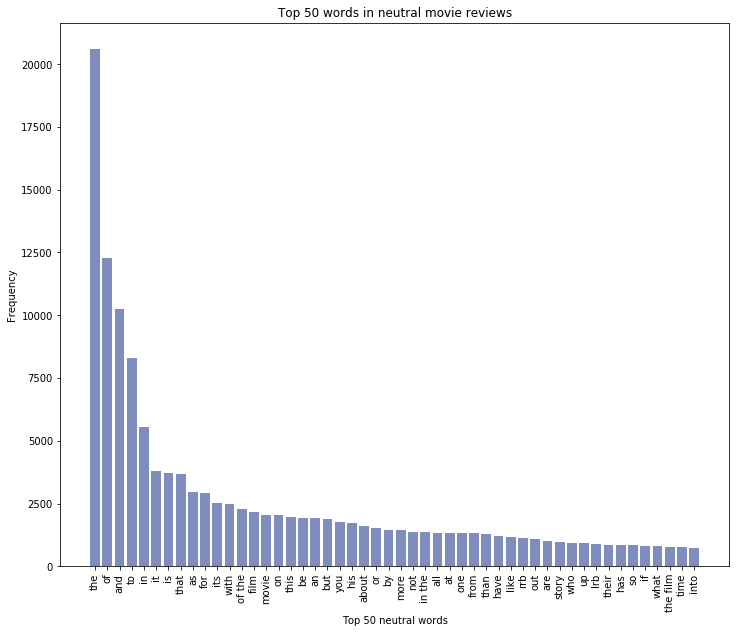

In [39]:
position = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(position, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:50], align='center', alpha=0.5)
plt.xticks(position, term_freq_df.sort_values(by='neutral', ascending=False)['neutral'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 neutral words')
plt.title('Top 50 words in neutral movie reviews')